# 手写数字识别

In [43]:
import copy
import math
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.transforms import *
from tqdm.auto import tqdm
import torch.nn.functional as F
from torchvision import datasets

In [44]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [45]:
# 设置归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# 获取数据集
train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集

# 设置DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

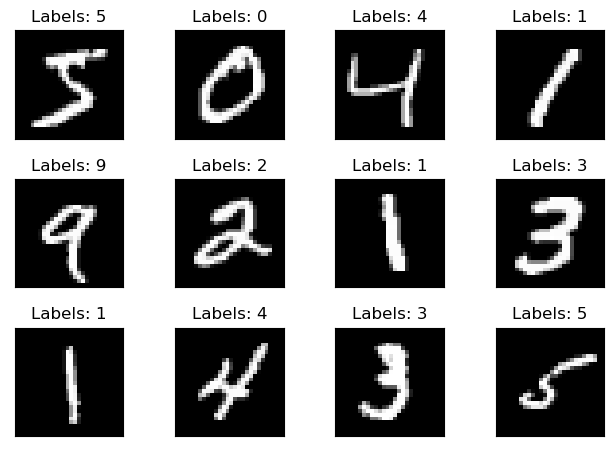

In [46]:
# 展示数据集
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [47]:
# 定义一个LeNet网络
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)

In [48]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    inputs = inputs
    targets = targets

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer 
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [49]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [50]:
lr = 0.01
momentum = 0.5
num_epoch = 5

optimizer = torch.optim.SGD(model.parameters(),  lr=lr, momentum=momentum)  # lr学习率，momentum冲量
criterion = nn.CrossEntropyLoss()  # 交叉熵损失


best_accuracy = 0
best_checkpoint = dict()
gradients = dict()
for epoch in range(num_epoch):
    train(model, train_loader, criterion, optimizer)
    accuracy = evaluate(model, test_loader)
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
        
        # 将每个梯度保存到字典中
        for name, parameter in model.named_parameters():
            if parameter.grad is not None:
                # .clone()确保我们有梯度的复制，而非引用
                gradients[name] = parameter.grad.clone()

    print(f'Epoch{epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')


torch.save(best_checkpoint['state_dict'], './model.pt')
torch.save(gradients, './model_gradients.pt')

print(f"=> loading best checkpoint")
model.load_state_dict(best_checkpoint['state_dict'])

train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 Accuracy 93.96% / Best Accuracy: 93.96%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 Accuracy 97.41% / Best Accuracy: 97.41%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 Accuracy 97.99% / Best Accuracy: 97.99%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 Accuracy 97.59% / Best Accuracy: 97.99%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 Accuracy 97.61% / Best Accuracy: 97.99%
=> loading best checkpoint


<All keys matched successfully>

In [51]:
model_accuracy = evaluate(model, test_loader)
print(f"Model has accuracy={model_accuracy:.2f}%")

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Model has accuracy=97.99%
